# Data and packages imports

In [1]:
import keras
from keras import layers
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image_dataset_from_directory
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os, shutil
from keras import regularizers
from sklearn import metrics
import seaborn as sns
import numpy
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Settings

In [3]:
patience = 5
size = 256
seed = 7

# Data pre processing


In [4]:
#Augmentation
train_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

val_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                    'drive/MyDrive/project_data/train',
                    target_size = (size, size),
                    batch_size = 32,
                  class_mode = 'binary',
                  seed = seed)

validation_generator = val_datagen.flow_from_directory(
                    'drive/MyDrive/project_data/val',
                    target_size = (size, size),
                    batch_size = 32,
                    class_mode = 'binary',
                    shuffle = False,
                    seed = seed)

test_data_generator = test_generator.flow_from_directory(
                    'drive/MyDrive/project_data/test', 
                     target_size=(size, size),
                     batch_size=32,
                     shuffle=False,
                     seed = seed)

Found 13450 images belonging to 18 classes.
Found 2529 images belonging to 18 classes.
Found 619 images belonging to 18 classes.


In [5]:
train_generator

In [6]:
pd.Series(train_generator.classes).value_counts()

8     996
9     960
13    959
7     902
17    856
14    848
16    826
11    802
4     790
10    787
6     715
0     676
3     665
5     665
2     630
1     579
12    561
15    233
dtype: int64

# Re-sorting data

In [7]:
# os.mkdir(os.path.join('drive', 'MyDrive','project_data','train_bal'))

# for genre in os.listdir(os.path.join('drive', 'MyDrive','project_data','train')):

#   os.mkdir(os.path.join('drive', 'MyDrive','project_data','train_bal', genre))
#   paintings = os.listdir(os.path.join('drive', 'MyDrive','project_data','train', genre))

#   for painting in paintings[:233]:

#     src = os.path.join('drive', 'MyDrive','project_data','train', genre, painting)
#     dst = os.path.join('drive', 'MyDrive','project_data','train_bal', genre, painting)
#     shutil.copyfile(src, dst)

In [8]:
train_bal_datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

train_bal_generator = train_datagen.flow_from_directory(
                    'drive/MyDrive/project_data/train_bal',
                    target_size = (size, size),
                    batch_size = 32,
                  class_mode = 'binary',
                  seed = seed)

Found 4194 images belonging to 18 classes.


# Functions

In [9]:
def plot_train_val_loss(history_dict, epochs):
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = epochs

    plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
    plt.plot(epochs, val_loss_values, 'b', label = 'Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [10]:
def plot_train_val_acc(history_dict, epochs):
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    
    epochs = epochs
    
    plt.plot(epochs, acc_values, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc_values, 'b', label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [11]:
def confusion_matrix_report(model):
  test_steps_per_epoch = numpy.math.ceil(test_data_generator.samples / test_data_generator.batch_size)
  predictions = model.predict(test_data_generator, steps=test_steps_per_epoch)
  predicted_classes = numpy.argmax(predictions, axis=1)
  true_classes = test_data_generator.classes
  class_labels = list(test_data_generator.class_indices.keys())
  report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
  cf = metrics.confusion_matrix(true_classes, predicted_classes)
  sns.heatmap(cf, annot=True, xticklabels=class_labels, yticklabels=class_labels)
  plt.show()
  print(report)

# ResNet50

In [ ]:
from keras.applications import ResNet50

model = models.Sequential()

model.add(ResNet50(weights = 'imagenet', include_top = False, input_shape= (256, 256, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(50, activation = 'sigmoid'))

model.layers[0].trainable = False

model.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                6450      
Total params: 40,388,018
Trainable params: 16,800,306
Non

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = 4)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False
            callbacks = [early_stopping]
            )

Epoch 1/100
421/421 [==============================] - 6489s 15s/step - loss: 6.1986 - accuracy: 0.0614 - val_loss: 2.9060 - val_accuracy: 0.0490
Epoch 2/100
421/421 [==============================] - 360s 856ms/step - loss: 2.8761 - accuracy: 0.0773 - val_loss: 2.8342 - val_accuracy: 0.0977
Epoch 3/100
421/421 [==============================] - 363s 862ms/step - loss: 2.8733 - accuracy: 0.0840 - val_loss: 2.8633 - val_accuracy: 0.0870
Epoch 4/100
421/421 [==============================] - 365s 868ms/step - loss: 2.8418 - accuracy: 0.0830 - val_loss: 2.8225 - val_accuracy: 0.1036
Epoch 5/100
421/421 [==============================] - 360s 855ms/step - loss: 2.8391 - accuracy: 0.0836 - val_loss: 3.2787 - val_accuracy: 0.0961
Epoch 6/100
421/421 [==============================] - 357s 849ms/step - loss: 2.8340 - accuracy: 0.0915 - val_loss: 2.7990 - val_accuracy: 0.0704
Epoch 7/100
421/421 [==============================] - 356s 846ms/step - loss: 2.8062 - accuracy: 0.0881 - val_loss: 2.

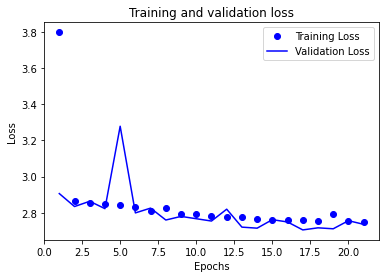

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy'])+1)
plot_train_val_loss(history_dict, epochs)

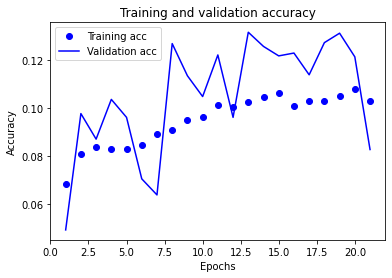

In [ ]:
plot_train_val_acc(history_dict, epochs)

# Model 1



In [ ]:
model = models.Sequential()

model = models.Sequential()

model.add(layers.Conv2D(96, (3,3), activation = 'relu',
                       input_shape= (256, 256, 3)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 96)      2688      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 252, 252, 96)      83040     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 126, 126, 96)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 124, 124, 192)     166080    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 122, 122, 192)     331968    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 192)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 59, 59, 384)      

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False
            callbacks = [early_stopping]
            )

Epoch 1/100
421/421 [==============================] - 365s 865ms/step - loss: 2.8801 - accuracy: 0.0690 - val_loss: 2.6949 - val_accuracy: 0.1198
Epoch 2/100
421/421 [==============================] - 363s 862ms/step - loss: 2.6937 - accuracy: 0.1214 - val_loss: 2.5875 - val_accuracy: 0.1586
Epoch 3/100
421/421 [==============================] - 362s 859ms/step - loss: 2.5178 - accuracy: 0.1730 - val_loss: 2.4616 - val_accuracy: 0.1744
Epoch 4/100
421/421 [==============================] - 363s 861ms/step - loss: 2.4369 - accuracy: 0.2010 - val_loss: 2.3423 - val_accuracy: 0.2270
Epoch 5/100
421/421 [==============================] - 365s 867ms/step - loss: 2.4151 - accuracy: 0.2111 - val_loss: 2.2941 - val_accuracy: 0.2543
Epoch 6/100
421/421 [==============================] - 370s 879ms/step - loss: 2.3591 - accuracy: 0.2178 - val_loss: 2.3015 - val_accuracy: 0.2452
Epoch 7/100
421/421 [==============================] - 370s 878ms/step - loss: 2.3199 - accuracy: 0.2264 - val_loss: 2

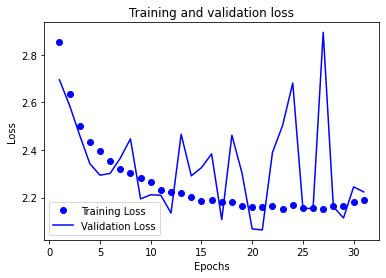

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

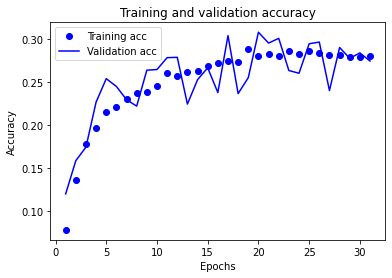

In [ ]:
plot_train_val_acc(history_dict, epochs)

# Model 2



In [ ]:
model = models.Sequential()

model = models.Sequential()

model.add(layers.Conv2D(96, (3,3), activation = 'relu', input_shape = (256, 256, 3)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))

# model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
# model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Dropout(0.2))
# model.add(layers.Conv2D(768, (3,3), activation = 'relu'))
# model.add(layers.Conv2D(768, (3,3), activation = 'relu'))
# model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
# model.add(layers.Dropout(0.2)) #####
#add regularization
model.add(layers.Dense(128, activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'relu', kernel_regularizer = regularizers.l1_l2(l1 = 0.001, l2 = 0.001)))
model.add(layers.Dropout(0.5))
# model.add(layers.Dense(256, activation = 'relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 254, 254, 96)      2688      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 252, 252, 96)      83040     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 250, 250, 96)      83040     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 248, 248, 96)      83040     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 246, 246, 96)      83040     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 123, 123, 96)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 123, 123, 96)     

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False
            callbacks = [early_stopping]
            )

Epoch 1/100
421/421 [==============================] - 489s 1s/step - loss: 47.3975 - accuracy: 0.0644 - val_loss: 40.3150 - val_accuracy: 0.0850
Epoch 2/100
421/421 [==============================] - 472s 1s/step - loss: 41.2701 - accuracy: 0.0753 - val_loss: 41.9066 - val_accuracy: 0.0850
Epoch 3/100
421/421 [==============================] - 470s 1s/step - loss: 41.2693 - accuracy: 0.0715 - val_loss: 40.8070 - val_accuracy: 0.0850
Epoch 4/100
421/421 [==============================] - 469s 1s/step - loss: 41.2563 - accuracy: 0.0681 - val_loss: 41.6773 - val_accuracy: 0.0850
Epoch 5/100
421/421 [==============================] - 465s 1s/step - loss: 41.2599 - accuracy: 0.0745 - val_loss: 40.8994 - val_accuracy: 0.0850
Epoch 6/100
421/421 [==============================] - 465s 1s/step - loss: 41.2566 - accuracy: 0.0748 - val_loss: 41.6406 - val_accuracy: 0.0850
Epoch 7/100
421/421 [==============================] - 465s 1s/step - loss: 41.2656 - accuracy: 0.0708 - val_loss: 40.9197 -

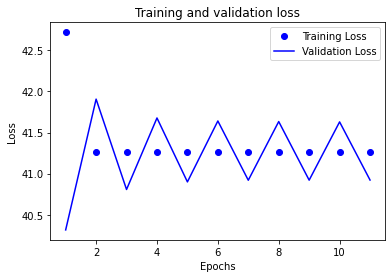

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

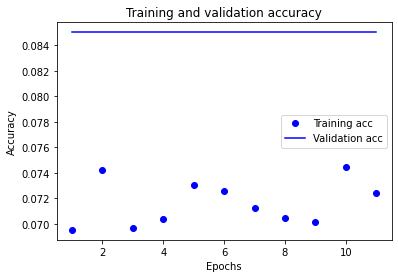

In [ ]:
plot_train_val_acc(history_dict, epochs)

# Model 3



In [ ]:
model = models.Sequential()

model = models.Sequential()

model.add(layers.Conv2D(96, (3,3), activation = 'relu',
                       input_shape= (256, 256, 3)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 254, 254, 96)      2688      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 252, 252, 96)      83040     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 126, 126, 96)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 126, 126, 96)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 124, 124, 192)     166080    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 122, 122, 192)     331968    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 61, 61, 192)      

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False
            callbacks = [early_stopping]
            )

Epoch 1/100
421/421 [==============================] - 357s 845ms/step - loss: 3.7082 - accuracy: 0.0638 - val_loss: 2.8765 - val_accuracy: 0.0668
Epoch 2/100
421/421 [==============================] - 355s 842ms/step - loss: 2.8634 - accuracy: 0.0711 - val_loss: 2.8760 - val_accuracy: 0.0850
Epoch 3/100
421/421 [==============================] - 355s 842ms/step - loss: 2.8566 - accuracy: 0.0768 - val_loss: 2.8785 - val_accuracy: 0.0850
Epoch 4/100
421/421 [==============================] - 354s 840ms/step - loss: 2.8568 - accuracy: 0.0713 - val_loss: 2.8753 - val_accuracy: 0.0850
Epoch 5/100
421/421 [==============================] - 353s 837ms/step - loss: 2.8603 - accuracy: 0.0739 - val_loss: 2.8741 - val_accuracy: 0.0850
Epoch 6/100
421/421 [==============================] - 353s 837ms/step - loss: 2.8589 - accuracy: 0.0758 - val_loss: 2.8766 - val_accuracy: 0.0850
Epoch 7/100
421/421 [==============================] - 352s 835ms/step - loss: 2.8564 - accuracy: 0.0700 - val_loss: 2

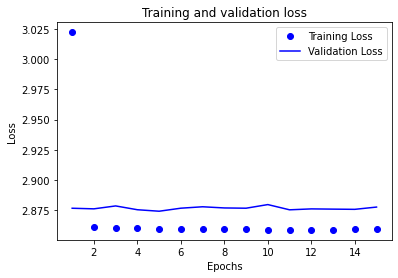

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

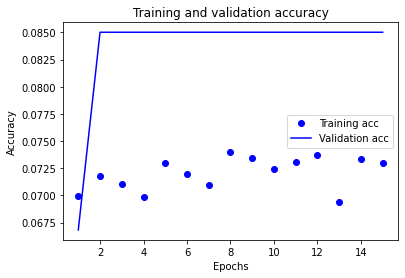

In [ ]:
plot_train_val_acc(history_dict, epochs)

# Model 4



In [ ]:
model = models.Sequential()

model = models.Sequential()

model.add(layers.Conv2D(96, (5,5), activation = 'relu',
                       input_shape= (128, 128, 3)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 96)      7296      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 96)      83040     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 96)      83040     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 192)       166080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 192)       331968    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 54, 54, 192)      

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False
            callbacks = [early_stopping]
            )

Epoch 1/100
421/421 [==============================] - 4401s 10s/step - loss: 2.8787 - accuracy: 0.0707 - val_loss: 2.8767 - val_accuracy: 0.0467
Epoch 2/100
421/421 [==============================] - 169s 401ms/step - loss: 2.8567 - accuracy: 0.0772 - val_loss: 2.8762 - val_accuracy: 0.0467
Epoch 3/100
421/421 [==============================] - 167s 397ms/step - loss: 2.8588 - accuracy: 0.0711 - val_loss: 2.8727 - val_accuracy: 0.0850
Epoch 4/100
421/421 [==============================] - 169s 402ms/step - loss: 2.8580 - accuracy: 0.0723 - val_loss: 2.8780 - val_accuracy: 0.0850
Epoch 5/100
421/421 [==============================] - 169s 401ms/step - loss: 2.8600 - accuracy: 0.0729 - val_loss: 2.8767 - val_accuracy: 0.0467
Epoch 6/100
421/421 [==============================] - 168s 400ms/step - loss: 2.8601 - accuracy: 0.0710 - val_loss: 2.8777 - val_accuracy: 0.0850
Epoch 7/100
421/421 [==============================] - 166s 394ms/step - loss: 2.8597 - accuracy: 0.0677 - val_loss: 2.

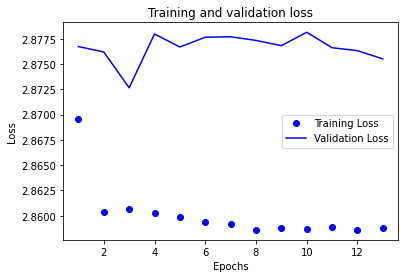

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

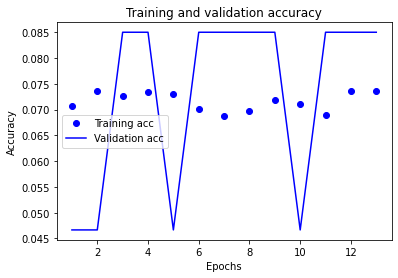

In [ ]:
plot_train_val_acc(history_dict, epochs)

# VGG19

In [12]:
from keras.applications import VGG19
model = models.Sequential()

model.add(VGG19(weights = 'imagenet', include_top = False, input_shape= (size, size, 3)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(18, activation = 'softmax'))

model.layers[0].trainable = False
model.summary()

80142336/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 18)                9234      
Total params: 37,074,002
Trainable params: 17,049,618
Non

In [13]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = 4)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False
            callbacks = [early_stopping]
            )

Epoch 1/100
 94/421 [=====>........................] - ETA: 1:19:31 - loss: 6.5191 - accuracy: 0.0971

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy'])+1)
plot_train_val_loss(history_dict, epochs)

In [ ]:
plot_train_val_acc(history_dict, epochs)

In [ ]:
confusion_matrix_report(model)

# Model 5



In [ ]:
model = models.Sequential()

model = models.Sequential()

model.add(layers.Conv2D(96, (3,3), activation = 'relu',
                       input_shape= (256, 256, 3)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.5))#lower?
model.add(layers.Dense(1024, activation = 'relu'))
model.add(layers.Dropout(0.5))#lower?

model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 254, 254, 96)      2688      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 252, 252, 96)      83040     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 126, 126, 96)      0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 124, 124, 192)     166080    
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 122, 122, 192)     331968    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 61, 61, 192)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 59, 59, 384)     

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False
            callbacks = [early_stopping]
            )

Epoch 1/100
421/421 [==============================] - 389s 884ms/step - loss: 3.0772 - accuracy: 0.0769 - val_loss: 2.7220 - val_accuracy: 0.1052
Epoch 2/100
421/421 [==============================] - 361s 858ms/step - loss: 2.6821 - accuracy: 0.1288 - val_loss: 2.5318 - val_accuracy: 0.1752
Epoch 3/100
421/421 [==============================] - 362s 859ms/step - loss: 2.5567 - accuracy: 0.1534 - val_loss: 3.1691 - val_accuracy: 0.0929
Epoch 4/100
421/421 [==============================] - 360s 855ms/step - loss: 2.4970 - accuracy: 0.1808 - val_loss: 2.4489 - val_accuracy: 0.2021
Epoch 5/100
421/421 [==============================] - 361s 857ms/step - loss: 2.4378 - accuracy: 0.1965 - val_loss: 3.4536 - val_accuracy: 0.1111
Epoch 6/100
421/421 [==============================] - 360s 854ms/step - loss: 2.3879 - accuracy: 0.2107 - val_loss: 2.3169 - val_accuracy: 0.2384
Epoch 7/100
421/421 [==============================] - 360s 854ms/step - loss: 2.3643 - accuracy: 0.2256 - val_loss: 2

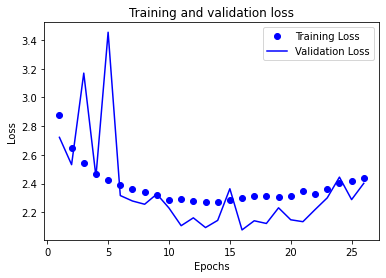

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

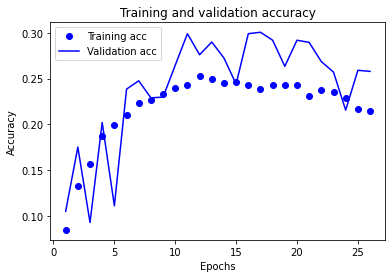

In [ ]:
plot_train_val_acc(history_dict, epochs)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


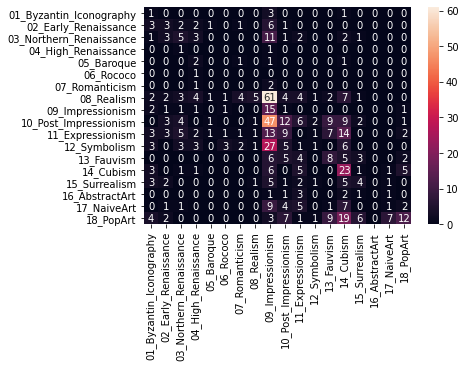

                         precision    recall  f1-score   support

01_Byzantin_Iconography       0.04      0.20      0.07         5
   02_Early_Renaissance       0.15      0.16      0.15        19
03_Northern_Renaissance       0.19      0.17      0.18        29
    04_High_Renaissance       0.00      0.00      0.00         2
             05_Baroque       0.00      0.00      0.00         5
              06_Rococo       0.00      0.00      0.00         1
         07_Romanticism       0.00      0.00      0.00         3
             08_Realism       0.56      0.05      0.09       102
       09_Impressionism       0.07      0.65      0.12        23
  10_Post_Impressionism       0.24      0.12      0.16        97
       11_Expressionism       0.00      0.00      0.00        63
           12_Symbolism       0.14      0.02      0.03        55
             13_Fauvism       0.22      0.24      0.23        33
              14_Cubism       0.23      0.50      0.31        46
          15_Surrealism 

In [ ]:
confusion_matrix_report(model)

# Model 1 - balanced



In [ ]:
model = models.Sequential()

model = models.Sequential()

model.add(layers.Conv2D(96, (3,3), activation = 'relu',
                       input_shape= (256, 256, 3)))
model.add(layers.Conv2D(96, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.Conv2D(192, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.Conv2D(384, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(18, activation = 'softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 254, 254, 96)      2688      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 252, 252, 96)      83040     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 126, 126, 96)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 124, 124, 192)     166080    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 122, 122, 192)     331968    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 61, 61, 192)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 59, 59, 384)     

In [ ]:
opti = keras.optimizers.RMSprop(momentum=0.1) 
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) 
metr = ['accuracy']

model.compile(optimizer = opti, 
              loss = loss, 
              metrics = metr)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss',
                              patience = patience)

history = model.fit( 
            train_bal_generator,
            epochs = 100,
            validation_data = validation_generator,
            # verbose = False
            callbacks = [early_stopping]
            )

Epoch 1/100
132/132 [==============================] - 132s 992ms/step - loss: 3.0651 - accuracy: 0.0500 - val_loss: 2.8886 - val_accuracy: 0.0482
Epoch 2/100
132/132 [==============================] - 129s 973ms/step - loss: 2.9378 - accuracy: 0.0715 - val_loss: 2.7899 - val_accuracy: 0.0949
Epoch 3/100
132/132 [==============================] - 129s 976ms/step - loss: 2.7914 - accuracy: 0.1077 - val_loss: 2.6593 - val_accuracy: 0.1408
Epoch 4/100
132/132 [==============================] - 129s 973ms/step - loss: 2.6839 - accuracy: 0.1287 - val_loss: 2.6397 - val_accuracy: 0.1427
Epoch 5/100
132/132 [==============================] - 127s 959ms/step - loss: 2.5929 - accuracy: 0.1504 - val_loss: 2.5626 - val_accuracy: 0.1487
Epoch 6/100
132/132 [==============================] - 126s 956ms/step - loss: 2.5381 - accuracy: 0.1647 - val_loss: 2.5292 - val_accuracy: 0.1771
Epoch 7/100
132/132 [==============================] - 126s 953ms/step - loss: 2.5162 - accuracy: 0.1793 - val_loss: 3

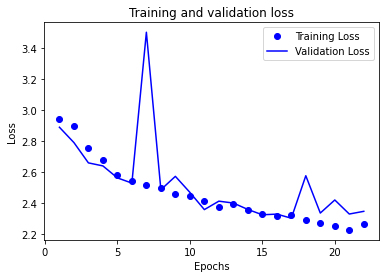

In [ ]:
history_dict = history.history
epochs = range(1, len(history_dict['accuracy']) + 1)
plot_train_val_loss(history_dict, epochs)

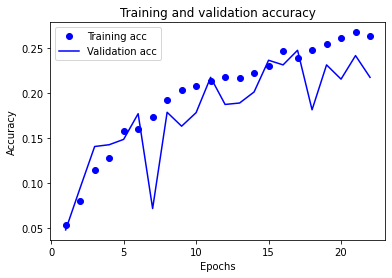

In [ ]:
plot_train_val_acc(history_dict, epochs)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


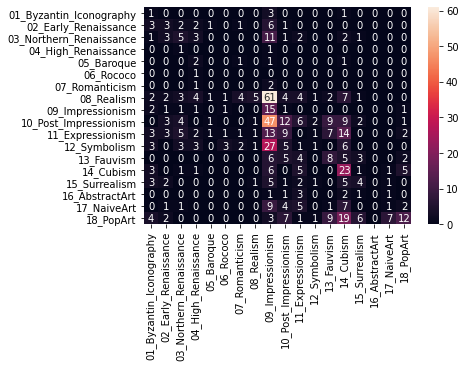

                         precision    recall  f1-score   support

01_Byzantin_Iconography       0.04      0.20      0.07         5
   02_Early_Renaissance       0.15      0.16      0.15        19
03_Northern_Renaissance       0.19      0.17      0.18        29
    04_High_Renaissance       0.00      0.00      0.00         2
             05_Baroque       0.00      0.00      0.00         5
              06_Rococo       0.00      0.00      0.00         1
         07_Romanticism       0.00      0.00      0.00         3
             08_Realism       0.56      0.05      0.09       102
       09_Impressionism       0.07      0.65      0.12        23
  10_Post_Impressionism       0.24      0.12      0.16        97
       11_Expressionism       0.00      0.00      0.00        63
           12_Symbolism       0.14      0.02      0.03        55
             13_Fauvism       0.22      0.24      0.23        33
              14_Cubism       0.23      0.50      0.31        46
          15_Surrealism 

In [ ]:
confusion_matrix_report()